# Recommender with splitted user 

In [146]:
import pandas as pd
import numpy as np 
import scipy.sparse as sps
import os
import sys
import matplotlib.pyplot as plt
sys.path.append('..')

dataset = pd.read_csv('data_train.csv')
dataset

,row,col,data
0,0,10080,1.0
1,0,19467,1.0
2,1,2665,1.0
3,1,7494,1.0
4,1,17068,1.0
...,...,...,...
113263,7945,2476,1.0
113264,7945,12319,1.0
113265,7945,21384,1.0
113266,7946,8699,1.0


In [147]:
users = dataset.row
items = dataset.col
data = dataset.data
URM_all = sps.coo_matrix((data, (users, items)))
URM_all = URM_all.tocsr() #fast row access -> fast access to users 
URM_all.shape

(7947, 25975)

In [148]:
items_per_user = np.ediff1d(URM_all.indptr) #tells in which position each of the rows begin
users_per_item = np.ediff1d(sps.csc_matrix(URM_all).indptr)
URM_all = sps.csr_matrix(URM_all)

In [149]:
items_per_user = np.sort(items_per_user) #sorting based on the single value. Losing reference to the user. 
users_per_item = np.sort(users_per_item)

In [150]:
ICM_df = pd.read_csv('data_ICM_title_abstract.csv')
ICM_df

,row,col,data
0,0,1185,1.015524
1,0,2507,0.459024
2,0,3534,0.227742
3,0,8766,0.501549
4,0,10862,0.297011
...,...,...,...
490686,25974,12554,0.963016
490687,25974,13003,0.104613
490688,25974,16236,0.118760
490689,25974,18797,0.363301


In [151]:
items = ICM_df.row
features = ICM_df.col
data = ICM_df.data
ICM_all = sps.coo_matrix((data, (items, features)))
ICM_all = ICM_all.tocsr() #fast row access -> fast access to users 
ICM_all.shape

(25975, 20000)

In [152]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [153]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

# Data pre-processing

In [154]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])

In [155]:
from GraphBased.P3alphaRecommender import P3alphaRecommender
from GraphBased.RP3betaRecommender import RP3betaRecommender
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender

recommender_alpha = P3alphaRecommender(URM_train)
recommender_alpha.fit(topK=170, alpha = 0.45, implicit = True)

recommender_beta_ICM = RP3betaRecommender(ICM_all.T)
recommender_beta_ICM.fit(topK=70, alpha=0.2, beta=0.5, implicit=False)
recommender_beta_ICM.URM_train = URM_train

hybridrecommender = ItemKNNSimilarityHybridRecommender(URM_train, recommender_alpha.W_sparse, recommender_beta_ICM.W_sparse)
hybridrecommender.fit(topK=200, alpha = 0.1)

evaluator_validation.evaluateRecommender(hybridrecommender)

P3alphaRecommender: URM Detected 45 (0.57 %) cold users.
P3alphaRecommender: URM Detected 1974 (7.60 %) cold items.
RP3betaRecommender: URM Detected 2 (0.01 %) cold users.
RP3betaRecommender: URM Detected 25 (0.10 %) cold items.
ItemKNNSimilarityHybridRecommender: URM Detected 45 (0.57 %) cold users.
ItemKNNSimilarityHybridRecommender: URM Detected 1974 (7.60 %) cold items.
EvaluatorHoldout: Processed 5022 ( 100.00% ) in 3.04 sec. Users per second: 1649


({10: {'ROC_AUC': 0.1911374634149431,
   'PRECISION': 0.039585822381520364,
   'PRECISION_RECALL_MIN_DEN': 0.16471019577351761,
   'RECALL': 0.16157481355237466,
   'MAP': 0.07623192467504276,
   'MRR': 0.13838689132894644,
   'NDCG': 0.11136733092091701,
   'F1': 0.06359168473411901,
   'HIT_RATE': 0.3958582238152131,
   'ARHR': 0.1576148280897389,
   'NOVELTY': 0.004969886832000951,
   'AVERAGE_POPULARITY': 0.08739527950131178,
   'DIVERSITY_MEAN_INTER_LIST': 0.9899327246115895,
   'DIVERSITY_HERFINDAHL': 0.9989735605391237,
   'COVERAGE_ITEM': 0.49724735322425406,
   'COVERAGE_ITEM_CORRECT': 0.04993262752646776,
   'COVERAGE_USER': 0.6319365798414496,
   'COVERAGE_USER_CORRECT': 0.18988297470743676,
   'DIVERSITY_GINI': 0.19464972537833836,
   'SHANNON_ENTROPY': 12.088308175663823}},
 'CUTOFF: 10 - ROC_AUC: 0.1911375, PRECISION: 0.0395858, PRECISION_RECALL_MIN_DEN: 0.1647102, RECALL: 0.1615748, MAP: 0.0762319, MRR: 0.1383869, NDCG: 0.1113673, F1: 0.0635917, HIT_RATE: 0.3958582, ARHR

In [156]:
from KNN.UserKNNCFRecommender import UserKNNCFRecommender

recommender_cold = UserKNNCFRecommender(URM_train)
recommender_cold.fit(shrink=100, topK=150, feature_weighting = "TF-IDF")
evaluator_validation.evaluateRecommender(recommender_cold)

UserKNNCFRecommender: URM Detected 45 (0.57 %) cold users.
UserKNNCFRecommender: URM Detected 1974 (7.60 %) cold items.
Similarity column 7947 ( 100 % ), 18655.31 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 5022 ( 100.00% ) in 3.13 sec. Users per second: 1606


({10: {'ROC_AUC': 0.16033508119828355,
   'PRECISION': 0.03219832735961707,
   'PRECISION_RECALL_MIN_DEN': 0.12707120416200485,
   'RECALL': 0.12431855908108694,
   'MAP': 0.058875522185879076,
   'MRR': 0.11539369630767451,
   'NDCG': 0.08746753657427336,
   'F1': 0.051149109251993743,
   'HIT_RATE': 0.32198327359617684,
   'ARHR': 0.13022036373290852,
   'NOVELTY': 0.004772251329546131,
   'AVERAGE_POPULARITY': 0.10778044880471538,
   'DIVERSITY_MEAN_INTER_LIST': 0.9856392240602214,
   'DIVERSITY_HERFINDAHL': 0.998544295977825,
   'COVERAGE_ITEM': 0.3482194417709336,
   'COVERAGE_ITEM_CORRECT': 0.0349181905678537,
   'COVERAGE_USER': 0.6319365798414496,
   'COVERAGE_USER_CORRECT': 0.1586762300239084,
   'DIVERSITY_GINI': 0.10102536213619728,
   'SHANNON_ENTROPY': 11.13419572203123}},
 'CUTOFF: 10 - ROC_AUC: 0.1603351, PRECISION: 0.0321983, PRECISION_RECALL_MIN_DEN: 0.1270712, RECALL: 0.1243186, MAP: 0.0588755, MRR: 0.1153937, NDCG: 0.0874675, F1: 0.0511491, HIT_RATE: 0.3219833, ARHR:

In [157]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

recommender_item_cf = ItemKNNCFRecommender(URM_train)
recommender_item_cf.fit(shrink=600, topK=550, feature_weighting = "TF-IDF")
evaluator_validation.evaluateRecommender(recommender_item_cf)

ItemKNNCFRecommender: URM Detected 45 (0.57 %) cold users.
ItemKNNCFRecommender: URM Detected 1974 (7.60 %) cold items.
Similarity column 25975 ( 100 % ), 7378.05 column/sec, elapsed time 0.06 min
EvaluatorHoldout: Processed 5022 ( 100.00% ) in 3.55 sec. Users per second: 1413


({10: {'ROC_AUC': 0.15873945907846793,
   'PRECISION': 0.03140183193946579,
   'PRECISION_RECALL_MIN_DEN': 0.12271726625071924,
   'RECALL': 0.11993694088178032,
   'MAP': 0.059176396844561545,
   'MRR': 0.11415106863135528,
   'NDCG': 0.08646031794346326,
   'F1': 0.049772303431478274,
   'HIT_RATE': 0.31401831939466346,
   'ARHR': 0.12940814384960125,
   'NOVELTY': 0.005033476206869896,
   'AVERAGE_POPULARITY': 0.0712998757130257,
   'DIVERSITY_MEAN_INTER_LIST': 0.9929296159634117,
   'DIVERSITY_HERFINDAHL': 0.99927318999905,
   'COVERAGE_ITEM': 0.4539364773820982,
   'COVERAGE_ITEM_CORRECT': 0.03842155919153032,
   'COVERAGE_USER': 0.6319365798414496,
   'COVERAGE_USER_CORRECT': 0.15364288410721028,
   'DIVERSITY_GINI': 0.16922848674333088,
   'SHANNON_ENTROPY': 12.064054365756613}},
 'CUTOFF: 10 - ROC_AUC: 0.1587395, PRECISION: 0.0314018, PRECISION_RECALL_MIN_DEN: 0.1227173, RECALL: 0.1199369, MAP: 0.0591764, MRR: 0.1141511, NDCG: 0.0864603, F1: 0.0497723, HIT_RATE: 0.3140183, ARHR

In [158]:
recommeder_KNNItemCBF = ItemKNNCBFRecommender(URM_train, ICM_all)
recommeder_KNNItemCBF.fit(topK=100, shrink=400, feature_weighting = 'TF-IDF')

ItemKNNCBFRecommender: URM Detected 45 (0.57 %) cold users.
ItemKNNCBFRecommender: URM Detected 1974 (7.60 %) cold items.
Similarity column 25975 ( 100 % ), 5142.82 column/sec, elapsed time 0.08 min


In [159]:
from Base.NonPersonalizedRecommender import TopPop

recommender_top_popular = TopPop(URM_train)
recommender_top_popular.fit()

TopPopRecommender: URM Detected 45 (0.57 %) cold users.
TopPopRecommender: URM Detected 1974 (7.60 %) cold items.


In [160]:
# userei un CF per warm 
# CBF per i cold 

In [161]:

grouped_users = dataset.groupby(['row']).count()
MAP_p3aplha_rp3beta_per_group = []
MAP_user_cf_cold_per_group = []
MAP_item_cf_cold_per_group = []
MAP_item_cbf_per_group = []
MAP_top_pop_per_group = []
cutoff = 10

users_not_in_group = grouped_users.copy()
users_not_in_group = users_not_in_group.loc[users_not_in_group.col >= 3]
users_not_in_group = users_not_in_group.reset_index()['row']

evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)

results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
MAP_item_cbf_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
MAP_top_pop_per_group.append(results[cutoff]["MAP"])

users_not_in_group = grouped_users.copy()
users_not_in_group = users_not_in_group.loc[(users_not_in_group['col'] < 3) | (users_not_in_group['col'] > 10)]
users_not_in_group = users_not_in_group.reset_index()['row']

evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)

results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
MAP_item_cbf_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
MAP_top_pop_per_group.append(results[cutoff]["MAP"])

users_not_in_group = grouped_users.copy()
users_not_in_group = users_not_in_group.loc[users_not_in_group.col <= 10]
users_not_in_group = users_not_in_group.reset_index()['row']

evaluator_p3_rp3 = EvaluatorHoldout(URM_validation, cutoff_list=[cutoff], ignore_users = users_not_in_group)

results, _ = evaluator_p3_rp3.evaluateRecommender(hybridrecommender)
MAP_p3aplha_rp3beta_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_cold)
MAP_user_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_item_cf)
MAP_item_cf_cold_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommeder_KNNItemCBF)
MAP_item_cbf_per_group.append(results[cutoff]["MAP"])
results, _ = evaluator_p3_rp3.evaluateRecommender(recommender_top_popular)
MAP_top_pop_per_group.append(results[cutoff]["MAP"])

EvaluatorHoldout: Ignoring 6859 Users
EvaluatorHoldout: Processed 302 ( 100.00% ) in 0.21 sec. Users per second: 1463
EvaluatorHoldout: Processed 302 ( 100.00% ) in 0.15 sec. Users per second: 1954
EvaluatorHoldout: Processed 302 ( 100.00% ) in 0.15 sec. Users per second: 2040
EvaluatorHoldout: Processed 302 ( 100.00% ) in 0.15 sec. Users per second: 2021
EvaluatorHoldout: Processed 302 ( 100.00% ) in 0.20 sec. Users per second: 1529
EvaluatorHoldout: Ignoring 3322 Users
EvaluatorHoldout: Processed 2595 ( 100.00% ) in 1.60 sec. Users per second: 1623
EvaluatorHoldout: Processed 2595 ( 100.00% ) in 1.53 sec. Users per second: 1699
EvaluatorHoldout: Processed 2595 ( 100.00% ) in 1.53 sec. Users per second: 1698
EvaluatorHoldout: Processed 2595 ( 100.00% ) in 1.47 sec. Users per second: 1766
EvaluatorHoldout: Processed 2595 ( 100.00% ) in 2.01 sec. Users per second: 1293
EvaluatorHoldout: Ignoring 5713 Users
EvaluatorHoldout: Processed 2125 ( 100.00% ) in 1.65 sec. Users per second: 1286


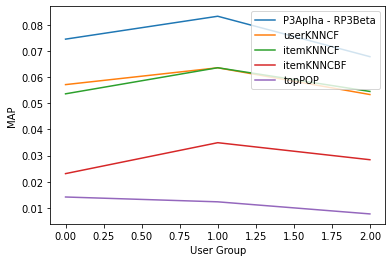

In [162]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(MAP_p3aplha_rp3beta_per_group, label="P3Aplha - RP3Beta")
pyplot.plot(MAP_user_cf_cold_per_group, label="userKNNCF")
pyplot.plot(MAP_item_cf_cold_per_group, label="itemKNNCF")
pyplot.plot(MAP_item_cbf_per_group, label="itemKNNCBF")
pyplot.plot(MAP_top_pop_per_group, label="topPOP")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()